# Adversarial Attacks

In [1]:
import numpy as np
import tensorflow as tf
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
from keras.backend import argmax
from keras.models import load_model
from numpy import atleast_2d
from pandas import DataFrame, concat

from data.file import model_convolutional_dataset, adversarial_images
from data.load import load_train_dataset, load_test_dataset
from reporting.images import display_dataframe

In [2]:
model = load_model(model_convolutional_dataset)

In [3]:
batch_size = 20
x_train, y_train = load_train_dataset(normalize=True)
x_test, y_test = load_test_dataset(normalize=True)

train_input = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_input = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [4]:


# epsilon: input variation parameter
eps = 0.05
count = 3
test_acc_fgsm = tf.metrics.SparseCategoricalAccuracy()

real = []
labels = []
perturbed_image_all = []
perturbed_image_prediction = []

for x, y in train_input.take(count):

    y_pred = model.predict(x)

    # generate fgsm perturbed image and predict
    x_fgm = fast_gradient_method(model, x, eps, np.inf)
    y_pred_fgm = model.predict(x_fgm)

    prediction = argmax(y_pred_fgm).numpy()
    expectation = argmax(y_pred).numpy()
    print("| real:", y.numpy(), " | prediction (origin): ", expectation, " | prediction (fgm): ", prediction, " | accuracy:", test_acc_fgsm(y, y_pred_fgm).numpy().round(decimals=3), " |")

    real.extend(x.numpy())
    perturbed_image_all.extend(x_fgm.numpy())
    labels.extend(y.numpy())

    perturbed_image_prediction.extend(prediction)

| real: [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]  | prediction (origin):  [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]  | prediction (fgm):  [3 0 4 1 9 2 1 3 8 4 9 8 3 6 8 7 7 8 6 7]  | accuracy: 0.65  |
| real: [4 0 9 1 1 2 4 3 2 7 3 8 6 9 0 5 6 0 7 6]  | prediction (origin):  [4 0 9 1 1 2 4 3 2 7 3 8 6 9 0 5 6 0 7 6]  | prediction (fgm):  [4 0 7 1 2 3 4 3 7 8 3 3 6 7 0 5 6 0 2 6]  | accuracy: 0.625  |
| real: [1 8 7 9 3 9 8 5 9 3 3 0 7 4 9 8 0 9 4 1]  | prediction (origin):  [1 8 7 9 3 9 8 5 9 3 3 0 7 4 9 8 0 9 4 1]  | prediction (fgm):  [1 8 7 9 3 9 8 5 5 3 3 0 7 4 4 8 0 9 4 1]  | accuracy: 0.717  |


/Users/raffael/learn/fhnw/xai/xai-adversarial-attack/reporting/images.py:28: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(rows, cols, i + 1)


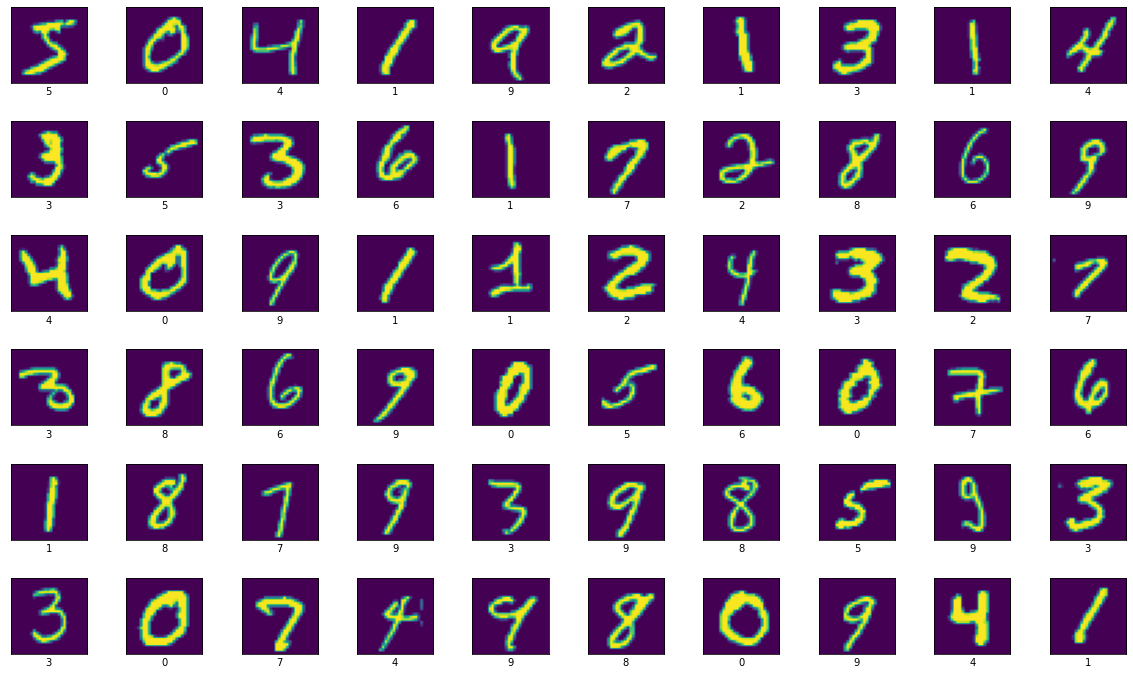

In [5]:
display_dataframe(real, labels=labels, cols=10)

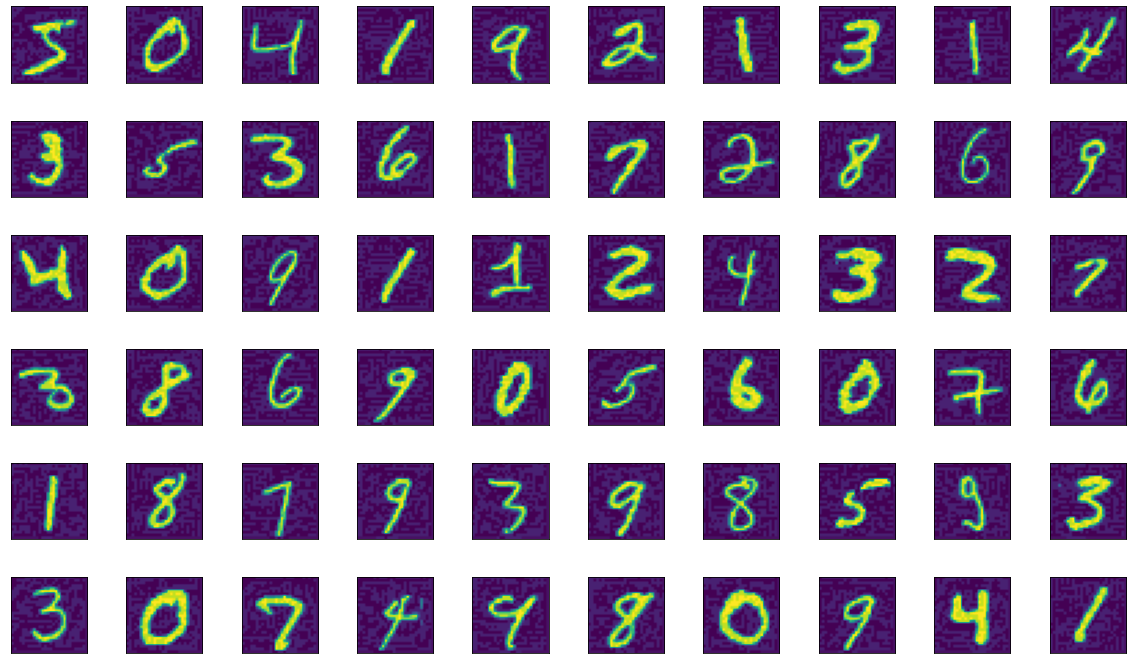

In [6]:
display_dataframe(perturbed_image_all, cols=10)

## Persist Images

In [7]:
np_perturbed_image_all = np.asarray(perturbed_image_all).astype(np.float32)
list_np_perturbed_image_all = np_perturbed_image_all.reshape((np_perturbed_image_all.shape[0], 28, 28, 1))

In [8]:

reshaped = np_perturbed_image_all.reshape((np_perturbed_image_all.shape[0], -1))
images_col = DataFrame([[img.astype('float32')] for img in reshaped], columns=["image"])

In [9]:
label = DataFrame(atleast_2d(labels).reshape(-1,1), columns=['label'])
perturbed_image_prediction = DataFrame(atleast_2d(perturbed_image_prediction).reshape(-1,1), columns=['prediction'])
attack_images = concat([images_col, label, perturbed_image_prediction], axis=1)
attack_images.to_parquet(adversarial_images)